### Intial setup, import libraries, define constants & initialize variables.

In [ ]:
!pip install transformers datasets torchvision tqdm

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from torch.utils.data.distributed import DistributedSampler
from tqdm.auto import tqdm
import json
import warnings
import time

# Suppress warnings for cleaner output
warnings.simplefilter("ignore")

# Constants
MODEL_NAME = "resnet50"
NUM_CLASSES = 101
IMAGE_SIZE = 224
DATASET_NAME = "food101"
MODEL_SAVE_DIR = f"/content/models"
RESULTS_FILE = "/content/results_resnet50_food101.json"
BACKEND = "nccl"
EARLY_STOPPING_PATIENCE = 5
WORLD_SIZE = torch.cuda.device_count()  # Set world size based on available GPUs

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Metrics data for tracking
metrics_data = {
    "epochs": [],
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "system_model": torch.cuda.get_device_name(),
    "gpus_per_node": WORLD_SIZE,
    "node_count": 1,
    "job_completion_time": float('-inf'),
    "system_model": torch.cuda.get_device_name(),
    "gpus_per_node": torch.cuda.device_count(),
    "best_epoch": None,
    "best_accuracy": float('-inf'),
    "epoch_completion_time": [],
    "early_stopping_counter": 0
}

### Image Transformation Class

In [ ]:
class ImageTransforms:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __call__(self, examples):
        examples["image"] = [self.transform(image) for image in examples["image"]]
        return examples

### Model Defination

In [ ]:
class ResNetModelClass(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(ResNetModelClass, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)
        self.resnet50.fc = self.fc

    def forward(self, x):
        return self.resnet50(x)

### Trainer Class

In [ ]:
class Trainer:
    def __init__(self, model, device, loss_fn, optimizer):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def train_step(self, dataloader):
        self.model.train()
        train_loss, train_acc = 0, 0

        for batch in tqdm(dataloader, desc="Training Progress"):
            X, y = batch["image"].to(self.device), batch["label"].to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(X)
            loss = self.loss_fn(y_pred, y)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y)

        return train_loss / len(dataloader), train_acc / len(dataloader)

    def val_step(self, dataloader):
        self.model.eval()
        val_loss, val_acc = 0, 0

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validation Progress"):
                X, y = batch["image"].to(self.device), batch["label"].to(self.device)
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)
                val_loss += loss.item()
                val_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y)

        return val_loss / len(dataloader), val_acc / len(dataloader)


### Training Loop

In [ ]:
def main():
    epoch = 0
    epochs = 8
    val_loss, val_acc = 0, 0
    START_TIME = time.time()
    # Environment setup for a single node
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset
    dataset = load_dataset(DATASET_NAME, cache_dir="/content/data")
    transform = ImageTransforms()
    dataset["train"].set_transform(transform)
    dataset["validation"].set_transform(transform)

    # Create DataLoaders without DistributedSampler
    train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(dataset["validation"], batch_size=32, shuffle=False, num_workers=0)

    # Model setup
    model = ResNetModelClass().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='min',
                                                        patience=2,
                                                        factor=0.5,
                                                        verbose=True)
    trainer = Trainer(model, device, loss_fn, optimizer)

    # Freeze layers for the first 50% of epochs
    for param in model.resnet50.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # Training and validation loop
    for epoch in range(epochs):
        # Create CUDA events for this epoch
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        print(f"Epoch {epoch + 1} / {epochs}")

        # Unfreeze layers after 50% of the epochs
        if epoch == epochs // 2:
            for param in model.resnet50.parameters():
                param.requires_grad = True

        start_event.record()  # Start timing

        train_loss, train_acc = trainer.train_step(train_loader)
        val_loss, val_acc = trainer.val_step(val_loader)

        end_event.record()  # End timing
        torch.cuda.synchronize()  # Synchronize to ensure all CUDA operations are complete
        epoch_duration = start_event.elapsed_time(end_event) / 1000.0

        metrics_data["epochs"].append(epoch + 1)
        metrics_data["train_loss"].append(train_loss)
        metrics_data["val_loss"].append(val_loss)
        metrics_data["train_accuracy"].append(train_acc)
        metrics_data["val_accuracy"].append(val_acc)
        metrics_data["epoch_completion_time"].append(epoch_duration)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

    final_model = {"model": model,
                  "criterion": loss_fn,
                  "epochs": epoch,
                  "optimizer_state": optimizer.state_dict(),
                  'scheduler_state_dict': scheduler.state_dict(),
                  "model_state": model.state_dict(),
                  "val_loss_min": val_loss}
    MODEL_FULL = f"{MODEL_SAVE_DIR}/{MODEL_NAME}_final_model.pth"

    metrics_data["job_completion_time"] = time.time() - START_TIME
    # Save metrics to JSON
    with open(RESULTS_FILE, "w") as f:
        json.dump(metrics_data, f, indent=4)
    print(f"Training metrics saved to {RESULTS_FILE}")

if __name__ == "__main__":
    main()

Epoch 1 / 8


Training Progress:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/790 [00:00<?, ?it/s]

Train Loss: 2.4125, Train Acc: 0.4213
Val Loss: 1.7749, Val Acc: 0.5424
Epoch 2 / 8


Training Progress:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/790 [00:00<?, ?it/s]

Train Loss: 1.9668, Train Acc: 0.5116
Val Loss: 1.6674, Val Acc: 0.5708
Epoch 3 / 8


Training Progress:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/790 [00:00<?, ?it/s]

Train Loss: 1.8643, Train Acc: 0.5326
Val Loss: 1.6555, Val Acc: 0.5757
Epoch 4 / 8


Training Progress:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/790 [00:00<?, ?it/s]

Train Loss: 1.7934, Train Acc: 0.5494
Val Loss: 1.6474, Val Acc: 0.5782
Epoch 5 / 8


Training Progress:   0%|          | 0/2368 [00:00<?, ?it/s]

Plot saved as 'metrics_plot.png'


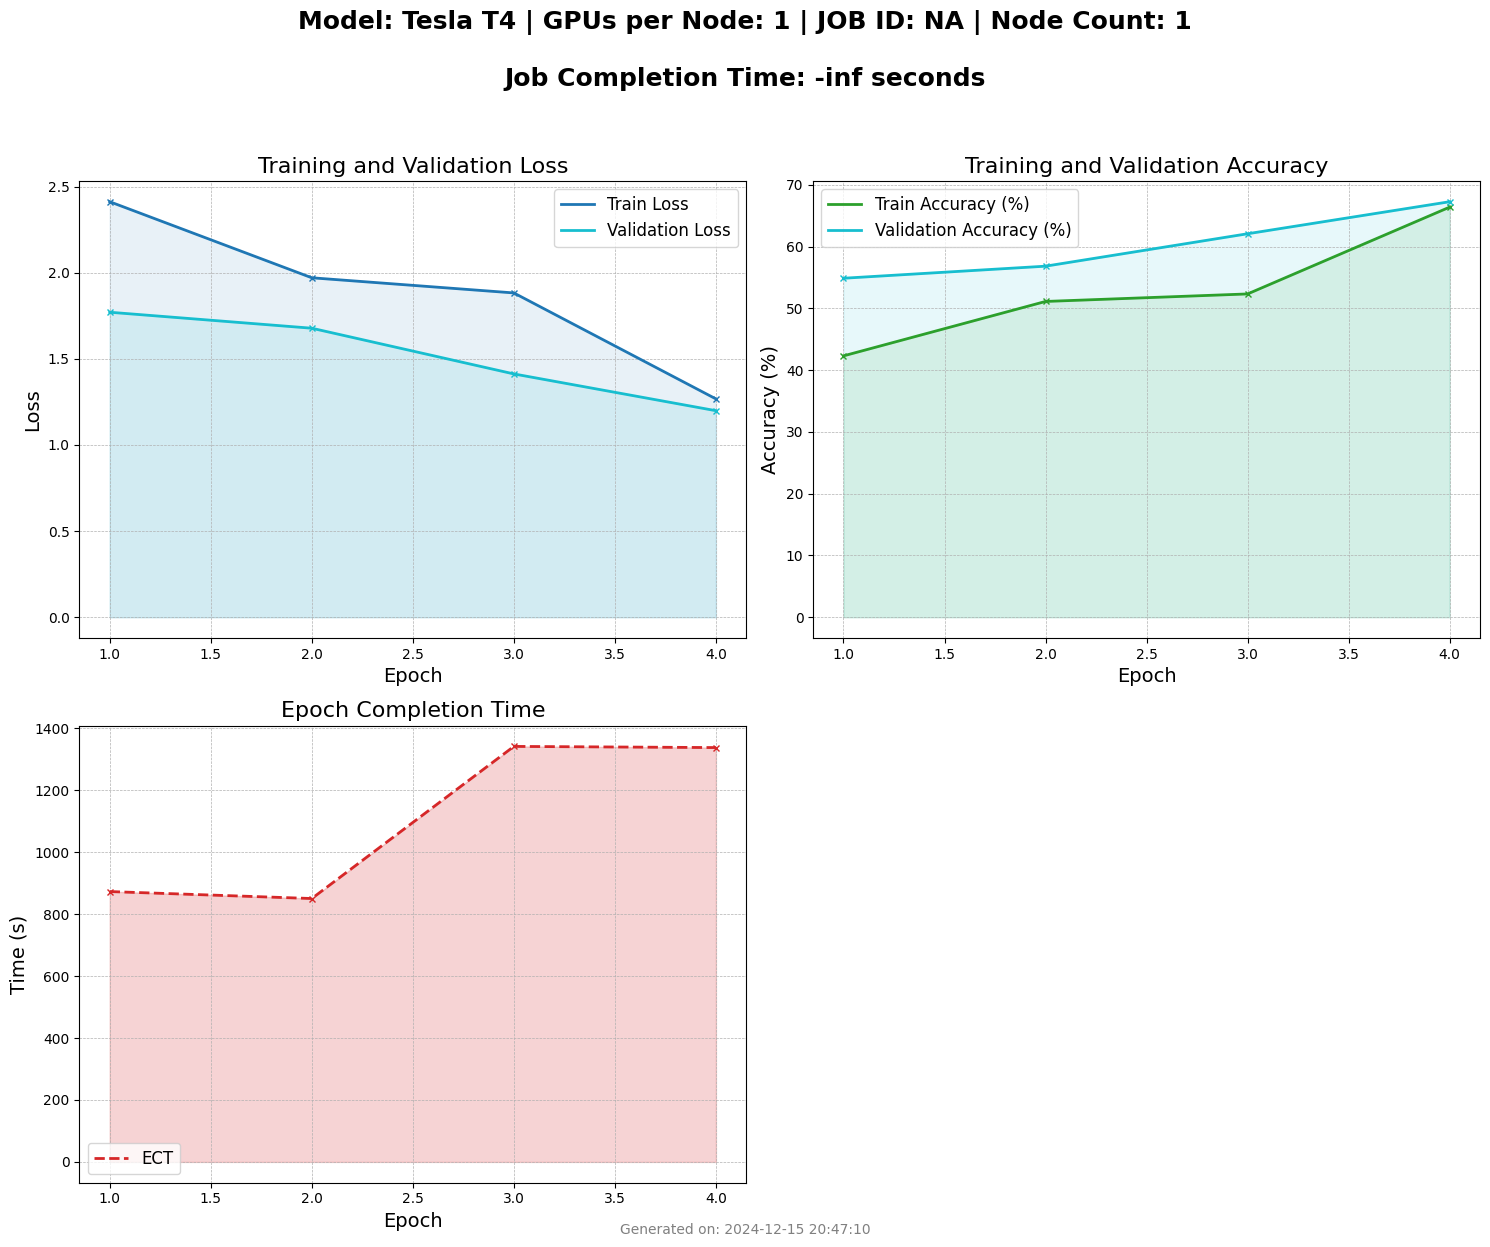

In [ ]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
import os

def plot_metrics(metrics_file, save_path="metrics_plot.png"):
    """
    Load training metrics from a JSON file and plot training/validation loss, accuracy, and epoch completion time.
    Save the plot to a specified file.

    Args:
    - metrics_file (str): Path to the JSON file containing the metrics.
    - save_path (str): Path to save the plot as a .png file.
    """
    # Load metrics from the JSON file
    if not os.path.exists(metrics_file):
        raise FileNotFoundError(f"Metrics file '{metrics_file}' not found.")

    with open(metrics_file, "r") as f:
        metrics = json.load(f)

    # Extract data from the JSON structure
    epochs = metrics["epochs"]
    train_losses = metrics["train_loss"]
    val_losses = metrics["val_loss"]
    train_accuracies = [acc * 100 for acc in metrics["train_accuracy"]]  # Convert to percentages
    val_accuracies = [acc * 100 for acc in metrics["val_accuracy"]]      # Convert to percentages
    epoch_completion_time = metrics["epoch_completion_time"]
    best_epoch = metrics["best_epoch"]
    best_accuracy = metrics["best_accuracy"] * 100 if metrics["best_accuracy"] is not None else None
    # Get system info for the title
    node_model = metrics["system_model"]
    gpus_per_node = metrics["gpus_per_node"]
    node_count = metrics["node_count"]
    job_completion_time = metrics["job_completion_time"]
    job_id = "NA"

    # Create a figure with 2 rows and 2 columns, but leave the last subplot (2,2) empty
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Adjusted for 2x2 grid layout

    # Add a main heading to the figure
    fig.suptitle(
        f"Model: {node_model} | GPUs per Node: {gpus_per_node} | JOB ID: {job_id} | Node Count: {node_count}\n\nJob Completion Time: {job_completion_time:.2f} seconds",
        fontsize=18, fontweight='bold', y=1.03
    )

    # --- Graph 1: Training and Validation Loss ---
    axs[0, 0].plot(epochs, train_losses, label="Train Loss", color='tab:blue', linewidth=2)
    axs[0, 0].plot(epochs, val_losses, label="Validation Loss", color='tab:cyan', linewidth=2)
    axs[0, 0].fill_between(epochs, train_losses, color='tab:blue', alpha=0.1)
    axs[0, 0].fill_between(epochs, val_losses, color='tab:cyan', alpha=0.1)
    axs[0, 0].plot(epochs, train_losses, 'x', color='tab:blue', markersize=5)
    axs[0, 0].plot(epochs, val_losses, 'x', color='tab:cyan', markersize=5)
    axs[0, 0].set_xlabel("Epoch", fontsize=14)
    axs[0, 0].set_ylabel("Loss", fontsize=14)
    axs[0, 0].set_title("Training and Validation Loss", fontsize=16)
    axs[0, 0].legend(loc="upper right", fontsize=12)
    axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Graph 2: Training and Validation Accuracy ---
    axs[0, 1].plot(epochs, train_accuracies, label="Train Accuracy (%)", color='tab:green', linewidth=2)
    axs[0, 1].plot(epochs, val_accuracies, label="Validation Accuracy (%)", color='tab:cyan', linewidth=2)
    axs[0, 1].fill_between(epochs, train_accuracies, color='tab:green', alpha=0.1)
    axs[0, 1].fill_between(epochs, val_accuracies, color='tab:cyan', alpha=0.1)
    axs[0, 1].plot(epochs, train_accuracies, 'x', color='tab:green', markersize=5)
    axs[0, 1].plot(epochs, val_accuracies, 'x', color='tab:cyan', markersize=5)
    if best_epoch is not None:
        axs[0, 1].annotate(
            f"Best Epoch {best_epoch}\nVal Acc: {best_accuracy:.2f}%",
            xy=(best_epoch, best_accuracy),
            xytext=(best_epoch - 2, best_accuracy - 15),
            fontsize=12,
            color='darkred',
            ha='center',
            arrowprops=dict(facecolor='darkred', arrowstyle='->', lw=2, shrinkA=0, shrinkB=5)
        )
    axs[0, 1].set_xlabel("Epoch", fontsize=14)
    axs[0, 1].set_ylabel("Accuracy (%)", fontsize=14)
    axs[0, 1].set_title("Training and Validation Accuracy", fontsize=16)
    axs[0, 1].legend(loc="upper left", fontsize=12)
    axs[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Graph 3: Epoch Completion Time ---
    axs[1, 0].plot(epochs, epoch_completion_time, label="ECT", color='tab:red', linewidth=2, linestyle='--')
    axs[1, 0].fill_between(epochs, epoch_completion_time, color='tab:red', alpha=0.2)
    axs[1, 0].plot(epochs, epoch_completion_time, 'x', color='tab:red', markersize=5)
    axs[1, 0].set_xlabel("Epoch", fontsize=14)
    axs[1, 0].set_ylabel("Time (s)", fontsize=14)
    axs[1, 0].set_title("Epoch Completion Time", fontsize=16)
    axs[1, 0].legend(loc="lower left", fontsize=12)
    axs[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Remove the empty subplot in the 2nd row and 2nd column
    fig.delaxes(axs[1, 1])

    # Add the timestamp as a footer
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    fig.text(0.5, 0.01, f"Generated on: {timestamp}", ha='center', fontsize=10, color='gray')

    # Layout adjustments to prevent clipping
    plt.tight_layout()

    # Save the plot as a .png file
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved as '{save_path}'")

plot_metrics('/content/results_resnet50_food101.json', 'metrics_plot.png')